In [1]:

import os

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

from binance.client import Client
api_key = os.environ.get('binance_api')
api_secret = os.environ.get('binance_secret')
client = Client(api_key, api_secret)

intervals = ['1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h', '1d', '3d', '1w', '1M']
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
earliest_day = '18 Aug, 2017'


In [2]:

def get_prices(start_date, end_date, time_interval, asset):
    
    '''
    Retrieves historical price data and stores opening prices in list titled openings
    '''
    
    # get candlesticks
    klines = client.get_historical_klines(asset, time_interval, start_date, end_date)

    # get opening values of each candlestick
    openings = []
    for j in range(len(klines)):
        openings.append(float(klines[j][1]))
    
    return(openings)


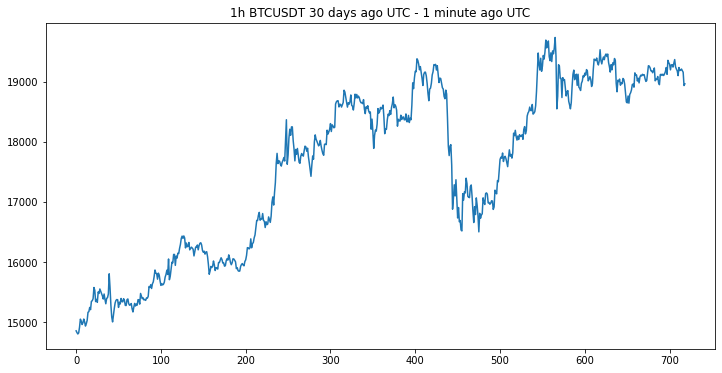

In [3]:

# init
time_interval = '1h'
asset = 'BTCUSDT'
start_date = '30 days ago UTC'
end_date = '1 minute ago UTC'

# get prices
openings = get_prices(start_date, end_date, time_interval, asset)

# plot
plt.plot(range(len(openings)),openings)
plt.title('{} {} {} - {}'.format(time_interval, asset, start_date, end_date))
plt.show()


# Apply SMAs
#### Simple moving averages (SMAs) are the average price over a specified time period

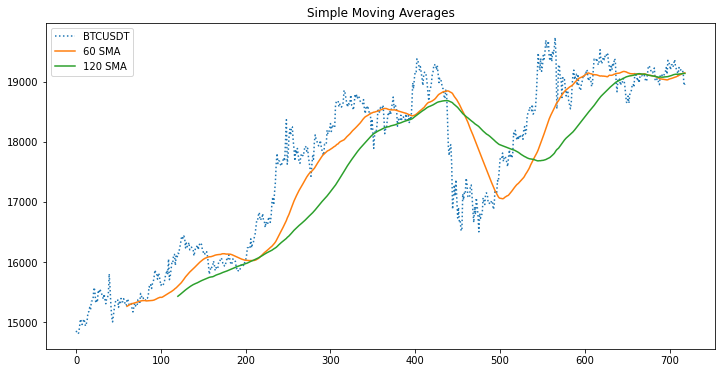

In [4]:

# init
# let SMA1 < SMA2
sma1_length = 60
sma2_length = 120

# compute sma1
sma1 = []
for i in range(sma1_length):
    sma1.append(None)
for i in range(len(openings) - sma1_length):
    sma1.append(sum(openings[i:i+sma1_length])/sma1_length)
    
# compute sma2
sma2 = []
for i in range(sma2_length):
    sma2.append(None)
for i in range(len(openings) - sma2_length):
    sma2.append(sum(openings[i:i+sma2_length])/sma2_length)
    
# plot
plt.plot(range(len(openings)), openings, ':', label = asset)
plt.plot(range(len(openings)), sma1, label = '{} SMA'.format(sma1_length))
plt.plot(range(len(openings)), sma2, label = '{} SMA'.format(sma2_length))
plt.title('Simple Moving Averages')
plt.legend()
plt.show()


# Determine SMA Crosses

This plot shows where SMA crossovers occur


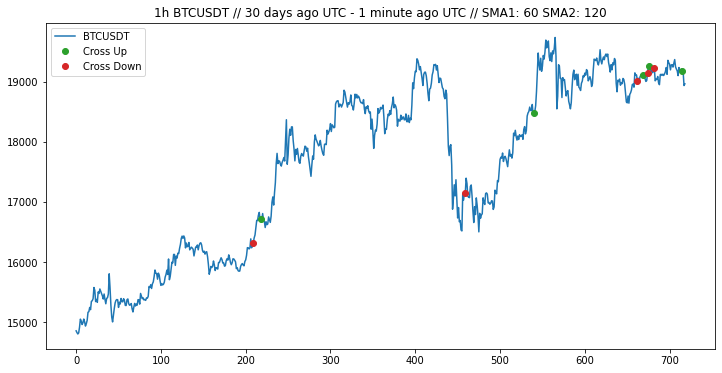

In [5]:

# subtraction is a list that crosses zero when the SMAs cross.
# it is the faster SMA subtracted from the slower SMA
subtraction = []
for i in range(sma2_length, len(sma2)):
    subtraction.append(sma2[i] - sma1[i])

# crossovers lists the index after a crossover occurred, starting at the index where the larger SMA begins
# crossUps and crossDowns refers to when SMA1 crosses SMA2 upwards or downwards
crossovers = []
crossUps = []
crossDowns = []
for i in range(1, len(subtraction)-1):
    if subtraction[i] * subtraction[i-1] < 0:
        if subtraction[i] > 0:
            crossovers.append(sma2_length+i)
            crossDowns.append(sma2_length+i)
        else:
            crossovers.append(sma2_length+i)
            crossUps.append(sma2_length+i)     
    elif subtraction[i] == 0:
        for m in range(1000):
            if subtraction[i-m] == 0:
                pass
            else:
                if subtraction[i-m] < 0 and subtraction[i+1] > 0:
                    crossovers.append(sma2_length+i+1)
                    crossDowns.append(sma2_length+i+1)
                    break
                elif subtraction[i-m] > 0 and subtraction[i+1] < 0:
                    crossovers.append(sma2_length+i+1)
                    crossUps.append(sma2_length+i+1)
                    break
                else:
                    break
            
# lists of the asset prices at the crossover indices
crossoverlist = []
for i in crossovers:
    crossoverlist.append(openings[i])
crossUplist = []
for i in crossUps:
    crossUplist.append(openings[i])
crossDownlist = []
for i in crossDowns:
    crossDownlist.append(openings[i])

# plot
print('This plot shows where SMA crossovers occur')
plt.plot(range(len(openings)),openings, label = asset)
plt.plot(crossUps,crossUplist,'o', c='C2', label='Cross Up'.format(sma1_length))
plt.plot(crossDowns,crossDownlist,'o', c='C3', label='Cross Down'.format(sma2_length))
plt.title('{} {} // {} - {} // SMA1: {} SMA2: {}'.format(time_interval, asset, start_date, end_date, sma1_length, sma2_length))
plt.legend()
plt.show()


### If you buy a full bitcoin at each buy, and short a full bitcoin at each sell, closing any open position at the start of each new trade...

In [6]:

gain = 0

if crossovers[0] in crossUps:
    if len(crossUps) == len(crossDowns):
        for i in range(len(crossDownlist)-1):
            gain += crossDownlist[i] - crossUplist[i]
            gain += crossDownlist[i] - crossUplist[i+1]

        gain += crossDownlist[-1] - crossUplist[-1]
    
    else:
        for i in range(len(crossDownlist)):
            gain += crossDownlist[i] - crossUplist[i]
            gain += crossDownlist[i] - crossUplist[i+1]
    
    
elif crossovers[0] in crossDowns:
    if len(crossUps) == len(crossDowns):
        for i in range(len(crossUplist)-1):
            gain += crossDownlist[i] - crossUplist[i]
            gain += crossDownlist[i+1] - crossUplist[i]

        gain += crossDownlist[-1] - crossUplist[-1]
    
    else:
        for i in range(len(crossUplist)):
            gain += crossDownlist[i] - crossUplist[i]
            gain += crossDownlist[i+1] - crossUplist[i]
    
print('Dollar gain is ${:.2f}'.format(gain))


Dollar gain is $-923.49


# Iterate through possible combinations of SMAs

In [7]:

def sma_loop(openings, sma_range):
    
    '''
    Takes price data and a specified range in which
    every combination of two SMAs will be applied.
    Returns the gains that would be made for each SMA
    combination using the same buy/sell strategy as above.
    '''
    
    gainlist = []
    justgains = []
    for a in range(1, sma_range):
        for b in range(a+1, sma_range):
            
            # let SMA1 < SMA2
            sma1_length = a
            sma2_length = b

            # compute sma1
            sma1 = []
            for i in range(sma1_length):
                sma1.append(None)
            for i in range(len(openings) - sma1_length):
                sma1.append(sum(openings[i:i+sma1_length])/sma1_length)

            # compute sma2
            sma2 = []
            for i in range(sma2_length):
                sma2.append(None)
            for i in range(len(openings) - sma2_length):
                sma2.append(sum(openings[i:i+sma2_length])/sma2_length)

            # subtraction is a list that crosses zero when the SMAs cross.
            # it is the faster SMA subtracted from the slower SMA
            subtraction = []
            for i in range(sma2_length, len(sma2)):
                subtraction.append(sma2[i] - sma1[i])

            # crossovers lists the index in the openings list after a crossover occurred
            # crossUps and crossDowns refers to when SMA1 crosses up or down
            crossovers = []
            crossUps = []
            crossDowns = []
            for i in range(1, len(subtraction)-1):
                if subtraction[i] * subtraction[i-1] < 0:
                    if subtraction[i] > 0:
                        crossovers.append(sma2_length+i)
                        crossDowns.append(sma2_length+i)
                    else:
                        crossovers.append(sma2_length+i)
                        crossUps.append(sma2_length+i)     
                elif subtraction[i] == 0:
                    for m in range(1000):
                        if subtraction[i-m] == 0:
                            pass
                        else:
                            if subtraction[i-m] < 0 and subtraction[i+1] > 0:
                                crossovers.append(sma2_length+i+1)
                                crossDowns.append(sma2_length+i+1)
                                break
                            elif subtraction[i-m] > 0 and subtraction[i+1] < 0:
                                crossovers.append(sma2_length+i+1)
                                crossUps.append(sma2_length+i+1)
                                break
                            else:
                                break

            crossoverlist = []
            for i in crossovers:
                crossoverlist.append(openings[i])

            crossUplist = []
            for i in crossUps:
                crossUplist.append(openings[i])

            crossDownlist = []
            for i in crossDowns:
                crossDownlist.append(openings[i])

            gain = 0

            if crossovers[0] in crossUps:
                if len(crossUps) == len(crossDowns):
                    for i in range(len(crossDownlist)-1):
                        gain += crossDownlist[i] - crossUplist[i]
                        gain += crossDownlist[i] - crossUplist[i+1]

                    gain += crossDownlist[-1] - crossUplist[-1]

                else:
                    for i in range(len(crossDownlist)):
                        gain += crossDownlist[i] - crossUplist[i]
                        gain += crossDownlist[i] - crossUplist[i+1]

            elif crossovers[0] in crossDowns:
                if len(crossUps) == len(crossDowns):
                    for i in range(len(crossUplist)-1):
                        gain += crossDownlist[i] - crossUplist[i]
                        gain += crossDownlist[i+1] - crossUplist[i]

                    gain += crossDownlist[-1] - crossUplist[-1]

                else:
                    for i in range(len(crossUplist)):
                        gain += crossDownlist[i] - crossUplist[i]
                        gain += crossDownlist[i+1] - crossUplist[i]

            gainlist.append([float('%.2f'%gain),a,b])
            justgains.append(gain)
            
    return(gainlist, justgains)


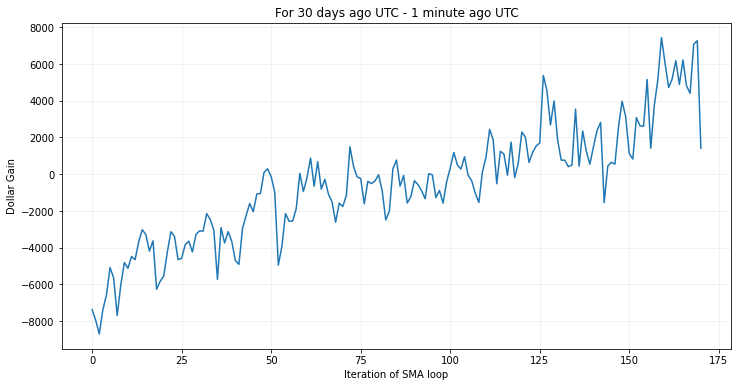

In [8]:

# init
n = 20

# execute
gainlist, justgains = sma_loop(openings, n)

# plot
plt.plot(range(len(gainlist)), justgains)
plt.xlabel('Iteration of SMA loop')
plt.ylabel('Dollar Gain')
plt.grid(alpha = 0.2)
plt.title('For {} - {}'.format(start_date, end_date))
plt.show()


#### What percentage of SMA combinations return positive gain?

In [9]:

pos = 0
neg = 0
for num in justgains:
    if num > 0:
        pos += 1
    if num < 0:
        neg += 1
        
print('{} pos, {} neg'.format(pos,neg))
print("{:.0f}".format(pos/(pos+neg)*100), '% of the SMA combinations return a positive gain')


73 pos, 98 neg
43 % of the SMA combinations return a positive gain


# Iterate through days
#### The current setup here iterates through each day June 1, 2018 - June 9, 2018

In [10]:

maxlist = []
time_range = 1
sma_range = 10
for i in range(1,10):
    
    start_date = "{} June, 2018".format(i)
    end_date = "{} June, 2018".format(i+time_range)
    time_interval = '1h'
    asset = 'BTCUSDT'

    openings = get_prices(start_date, end_date, time_interval, asset)

    gainlist, justgains = sma_loop(openings, sma_range)

    maxlist.append(max(gainlist))
    

### The below list shows the max gain that could have been possible for each day, along with the corresponding SMA combination.

In [11]:
maxlist

[[108.08, 1, 3],
 [160.15, 2, 3],
 [79.16, 2, 3],
 [63.28, 4, 5],
 [119.97, 6, 7],
 [117.61, 7, 9],
 [98.65, 6, 7],
 [103.27, 2, 4],
 [96.42, 4, 5]]

### Percent positive gains

#### This iterates through each month of 2019 for the given time interval and returns the percent of SMA combinations that return a positive gain

In [12]:
percent = []
time_interval = '1h'
for k in range(0,11):
    openings = get_prices("1 {}, 2019".format(months[k]), "1 {}, 2019".format(months[k+1]), time_interval, 'BTCUSDT')
    gainlist, justgains = sma_loop(openings, 10)
    
    pos = 0
    neg = 0
    for num in justgains:
        if num > 0:
            pos += 1
        if num <= 0:
            neg += 1
    percentage = pos/(pos+neg)*100
    
    percent.append([float('%.2f'%percentage), months[k]])

In [13]:
percent

[[52.78, 'Jan'],
 [72.22, 'Feb'],
 [5.56, 'March'],
 [22.22, 'April'],
 [63.89, 'May'],
 [66.67, 'June'],
 [33.33, 'July'],
 [8.33, 'Aug'],
 [63.89, 'Sept'],
 [86.11, 'Oct'],
 [72.22, 'Nov']]